**Import statements**


In [19]:
import pandas as pd
from datetime import datetime
from datetime import timedelta
import numpy as np
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

import constants
import functions

%matplotlib inline

**Load Data**

In [20]:
all_static_data = functions.load_static_sensors_calibrated()
all_static_data = functions.transform_to_grid_coordinates(all_static_data)
mobile_sensor_data = functions.load_mobile_sensors()
mobile_sensor_data = functions.transform_to_grid_coordinates(mobile_sensor_data)

**Compute predictions for stationary sensors**

In [42]:
mae = []
mse = []
squares = []
pred=[]
values_read=[]


start_time = '2018-07-03 00:00:00'
start_window = '2018-07-05 12:00:00'
end_window = '2018-07-05 12:15:00'
offset_timeint = 1

number_of_windows = 100
window = 15
par_grid = functions.create_par()
timeint_on_first_window = 0

for i in range(1, number_of_windows+1):
    end_time = start_window
    # treinar sem dados moveis
    # testar em dados fixos em vez de móveis
    timeint, par_grid = functions.train(all_static_data, None, start_time, end_time, par_grid, window, timeint_on_first_window)
    to_test = functions.test_mobile(par_grid, timeint, all_static_data, start_window, end_window, 1)
    squares.append(to_test.shape[0])
    mae.append(mean_absolute_error(to_test['PM2.5'], to_test['pred_PM2.5']))
    mse.append(mean_squared_error(to_test['PM2.5'], to_test['pred_PM2.5']))
    pred.append(to_test['pred_PM2.5'].values[0])
    values_read.append(to_test['PM2.5'].values[0])

    start_time = end_time
    start_window = (datetime.strptime(start_window, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=15)).strftime("%Y-%m-%d %H:%M:%S")
    end_window = (datetime.strptime(end_window, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=15)).strftime("%Y-%m-%d %H:%M:%S")
    timeint_on_first_window = timeint+1
    

In [22]:
# mae

In [23]:
mae_no_online = []
mse_no_online = []
squares_no_online = []
pred_no_online=[]
values_read=[]


window = 15
start_window = '2018-07-05 12:00:00'
end_window = '2018-07-05 12:15:00'
offset_timeint = 1
number_of_windows = 100
par_grid = functions.create_par()
start_time = '2018-07-03 00:00:00'
end_time = start_window
timeint, par_grid = functions.train(all_static_data, None, start_time, end_time, par_grid, window)


for i in range(1, number_of_windows+1):
    to_test = functions.test_mobile(par_grid, timeint, all_static_data, start_window, end_window, i)
    squares_no_online.append(to_test.shape[0])
    mae_no_online.append(mean_absolute_error(to_test['PM2.5'], to_test['pred_PM2.5']))
    mse_no_online.append(mean_squared_error(to_test['PM2.5'], to_test['pred_PM2.5']))
    pred_no_online.append(to_test['pred_PM2.5'].values[0])
    values_read.append(to_test['PM2.5'].values[0])
    start_window = (datetime.strptime(start_window, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=15)).strftime("%Y-%m-%d %H:%M:%S")
    end_window = (datetime.strptime(end_window, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=15)).strftime("%Y-%m-%d %H:%M:%S")

In [24]:
# mae_no_online

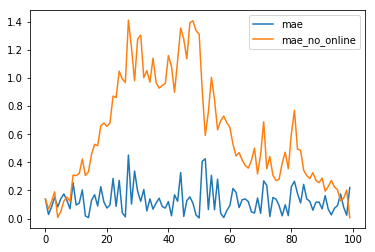

In [25]:
plt.plot(mae, label="mae")
plt.plot(mae_no_online, label="mae_no_online")
plt.legend(loc='best')
plt.show()


In [26]:
np.mean(mae)

0.13049569772549868

In [27]:
# np.mean(mae_no_online)

In [28]:
pred_offline=[]
par = PassiveAggressiveRegressor(max_iter=100, random_state=0,tol=1e-3)
start_window = '2018-07-03 00:00:00'
end_window = (datetime.strptime(start_window, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=window)).strftime("%Y-%m-%d %H:%M:%S")
window = 15
number_of_windows =100
list_ = []
timeint = 0
while end_window <= '2018-07-05 12:00:00':
    temp_sensor_data = all_static_data[(all_static_data['Timestamp'] > start_window) & (all_static_data['Timestamp'] < end_window) & (all_static_data['lat_grid'] == 4) & (all_static_data['long_grid'] == 6)]
    start_window = (datetime.strptime(start_window, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=window)).strftime("%Y-%m-%d %H:%M:%S")
    end_window = (datetime.strptime(end_window, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=window)).strftime("%Y-%m-%d %H:%M:%S")
    temp_sensor_data = temp_sensor_data.groupby(['lat_grid','long_grid']).mean()
    temp_sensor_data.reset_index(level=temp_sensor_data.index.names, inplace=True)
    temp_sensor_data['timeint'] = timeint
    list_.append(temp_sensor_data)
    timeint += 1
that_sensor_data = pd.concat(list_, axis = 0, ignore_index = False)
#print(that_sensor_data)
par.fit(that_sensor_data['timeint'].values.reshape(-1,1), that_sensor_data['PM2.5'])
print(par.coef_)
print(par.intercept_)
print(par.n_iter_)
for i in range(number_of_windows):
    pred_offline.append(par.predict([[timeint+i]])[0])

[-0.00823749]
[1.21266219]
14


In [29]:
# that_sensor_data

In [30]:
pred_baseline=[]
# Here make sure to include one more interval para ir buscar o valor inicial da previsao(ultimo do "treino")
start_window = '2018-07-05 11:45:00'
window = 15
end_window = (datetime.strptime(start_window, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=window)).strftime("%Y-%m-%d %H:%M:%S")
number_of_windows =100
for i in range(number_of_windows):
    temp_sensor_data = all_static_data[(all_static_data['Timestamp'] > start_window) & (all_static_data['Timestamp'] < end_window) & (all_static_data['lat_grid'] == 4) & (all_static_data['long_grid'] == 6)]
    start_window = (datetime.strptime(start_window, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=window)).strftime("%Y-%m-%d %H:%M:%S")
    end_window = (datetime.strptime(end_window, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=window)).strftime("%Y-%m-%d %H:%M:%S")
    temp_sensor_data = temp_sensor_data.groupby(['lat_grid','long_grid']).mean()
    temp_sensor_data.reset_index(level=temp_sensor_data.index.names, inplace=True)
    pred_baseline.append(temp_sensor_data['PM2.5'].values[0])


In [31]:
pred_baseline_60min=[]
# Here make sure to include one more interval para ir buscar o valor inicial da previsao(ultimo do "treino")
start_window = '2018-07-05 11:00:00'
window = 15
end_window = (datetime.strptime(start_window, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=window)).strftime("%Y-%m-%d %H:%M:%S")
number_of_windows =100
for i in range(number_of_windows):
    temp_sensor_data = all_static_data[(all_static_data['Timestamp'] > start_window) & (all_static_data['Timestamp'] < end_window) & (all_static_data['lat_grid'] == 4) & (all_static_data['long_grid'] == 6)]
    start_window = (datetime.strptime(start_window, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=window)).strftime("%Y-%m-%d %H:%M:%S")
    end_window = (datetime.strptime(end_window, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=window)).strftime("%Y-%m-%d %H:%M:%S")
    temp_sensor_data = temp_sensor_data.groupby(['lat_grid','long_grid']).mean()
    temp_sensor_data.reset_index(level=temp_sensor_data.index.names, inplace=True)
    pred_baseline_60min.append(temp_sensor_data['PM2.5'].values[0])

In [32]:
pred_baseline_24h=[]
# Here make sure to include one more interval para ir buscar o valor inicial da previsao(ultimo do "treino")
start_window = '2018-07-04 12:00:00'
window = 15
end_window = (datetime.strptime(start_window, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=window)).strftime("%Y-%m-%d %H:%M:%S")
number_of_windows =100
for i in range(number_of_windows):
    temp_sensor_data = all_static_data[(all_static_data['Timestamp'] > start_window) & (all_static_data['Timestamp'] < end_window) & (all_static_data['lat_grid'] == 4) & (all_static_data['long_grid'] == 6)]
    start_window = (datetime.strptime(start_window, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=window)).strftime("%Y-%m-%d %H:%M:%S")
    end_window = (datetime.strptime(end_window, '%Y-%m-%d %H:%M:%S') + timedelta(minutes=window)).strftime("%Y-%m-%d %H:%M:%S")
    temp_sensor_data = temp_sensor_data.groupby(['lat_grid','long_grid']).mean()
    temp_sensor_data.reset_index(level=temp_sensor_data.index.names, inplace=True)
    pred_baseline_24h.append(temp_sensor_data['PM2.5'].values[0])
    

In [33]:
# pred_baseline

In [34]:
# pred_offline
# pred_baseline

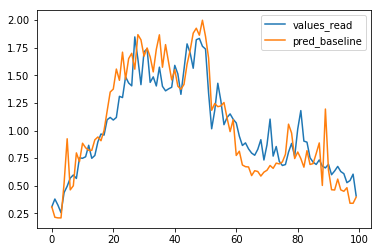

In [43]:
#plt.plot(pred_no_online, label="pred_no_online")
#plt.plot(pred, label="pred")
plt.plot(values_read, label="values_read")
#plt.plot(pred_offline, label="pred_offline")
plt.plot(pred_baseline, label="pred_baseline")
plt.legend(loc='best')
plt.show()

In [15]:
print("Baseline MAE:")
print (mean_absolute_error(values_read, pred_baseline))
print("Baseline MSE:")
print (mean_squared_error(values_read, pred_baseline))

print("Baseline 60 mins MAE:")
print (mean_absolute_error(values_read, pred_baseline_60min))
print("Baseline 60 mins MSE:")
print (mean_squared_error(values_read, pred_baseline_60min))

print("Baseline 24 hours MAE:")
print (mean_absolute_error(values_read, pred_baseline_24h))
print("Baseline 24 hours MSE:")
print (mean_squared_error(values_read, pred_baseline_24h))

Baseline MAE:
0.16030969761479702
Baseline MSE:
0.039885440113990644
Baseline 60 mins MAE:
0.17784877462610674
Baseline 60 mins MSE:
0.05892356486579093
Baseline 24 hours MAE:
0.43558279113541476
Baseline 24 hours MSE:
0.2925883901512358


In [17]:
# par_grid[9][5].coef_

In [17]:
# par_grid[9][5].intercept_

In [18]:
mean_absolute_error(values_read, pred)

0.13817034678569567

In [19]:
# plt.plot(np.abs(np.subtract(values_read, pred_no_online)))
# plt.plot(np.abs(np.subtract(values_read, pred)))

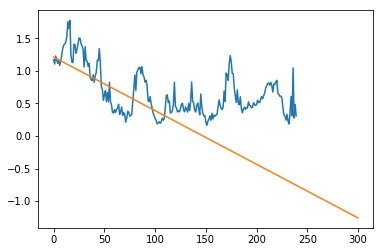

In [20]:
plt.plot(that_sensor_data['timeint'], that_sensor_data['PM2.5'])
x = np.linspace(0, 300, 300)
plt.plot(x, par.coef_[0]*x + par.intercept_[0])